In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Load the datasets
train_data = pd.read_csv('drug_review_train.csv')
test_data = pd.read_csv('drug_review_test.csv')
val_data = pd.read_csv('drug_review_validation.csv')

In [3]:
train_data.head(2)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136


In [4]:
test_data.head(2)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,163740,Mirtazapine,depression,"""i've tried a few antidepressants over the yea...",10.0,"February 28, 2012",22,68
1,1,206473,Mesalamine,"crohn's disease, maintenance","""my son has crohn's disease and has done very ...",8.0,"May 17, 2009",17,48


In [5]:
val_data.head(2)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,191114,Campral,alcohol dependence,"""sober a year 8-25-11. god, aa and campral hav...",10.0,"September 3, 2011",33,41
1,1,142693,Levonorgestrel,birth control,"""i've been on birth control for a while now du...",4.0,"August 9, 2017",3,140


In [6]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(110811, 9)
(46108, 9)
(27703, 9)


In [7]:
# Preprocess the text data
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

In [8]:
train_data['review'] = train_data['review'].apply(preprocess_text)
test_data['review'] = test_data['review'].apply(preprocess_text)
val_data['review'] = val_data['review'].apply(preprocess_text)

In [9]:
train_data.head(2)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,used restasis year seen almost progress life r...,2.0,"April 20, 2013",69,147
1,1,143975,Etonogestrel,birth control,experience somewhat mixed using implanon nearl...,7.0,"August 7, 2016",4,136


In [10]:
train_data['review'][0]

'used restasis year seen almost progress life red bothersome eye trying various eye drop doctor recommended restasis said typically take 3 6 month really kick never kick put drop burn eye first 30 40 minute talked doctor said normal go away time every year around spring time eye get terrible irritated year maybe even worse year even though using restasis year difference notice first couple week ready move'

In [11]:
# Map ratings to three sentiment labels (negative, neutral, positive)
def map_sentiment(rating):
    if 1 <= rating <= 3:
        return 'Negative'
    elif 4 <= rating <= 7:
        return 'Neutral'
    else:
        return 'Positive'

In [12]:
train_data['sentiment'] = train_data['rating'].apply(map_sentiment)
test_data['sentiment'] = test_data['rating'].apply(map_sentiment)
val_data['sentiment'] = val_data['rating'].apply(map_sentiment)

In [13]:
train_data.head(2)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,used restasis year seen almost progress life r...,2.0,"April 20, 2013",69,147,Negative
1,1,143975,Etonogestrel,birth control,experience somewhat mixed using implanon nearl...,7.0,"August 7, 2016",4,136,Neutral


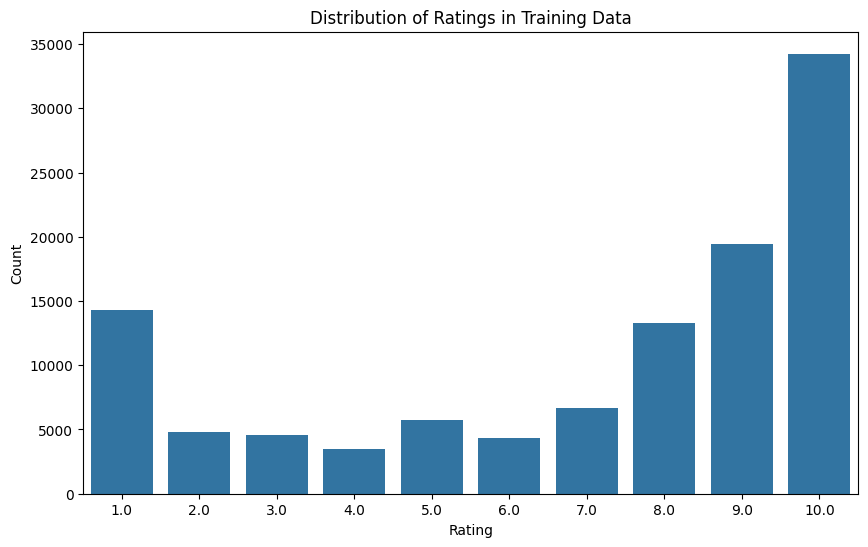

In [39]:
# EDA: Distribution of Ratings
plt.figure(figsize=(10, 6))
# sns.countplot(x='rating', data=train_data, palette='viridis')
# sns.countplot(x='rating', data=train_data, hue='some_group_variable')
sns.countplot(x='rating', data=train_data)

plt.title('Distribution of Ratings in Training Data')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

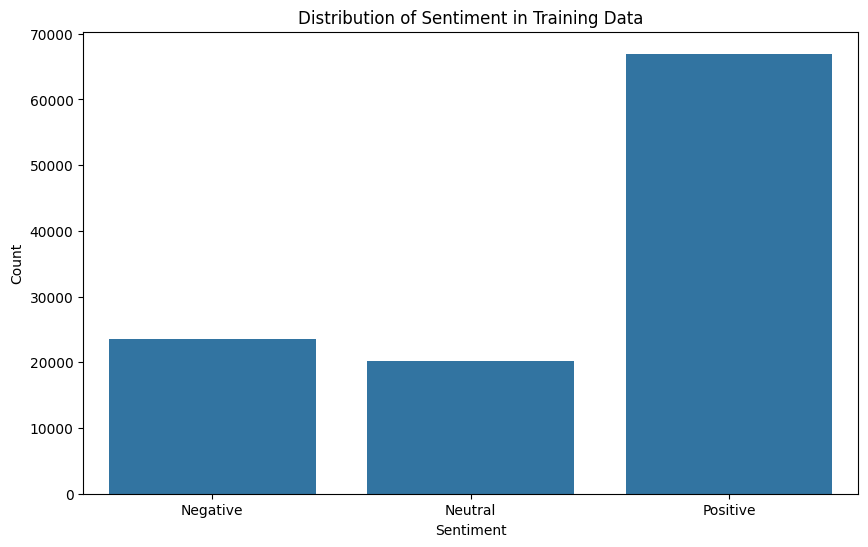

In [40]:
# EDA: Distribution of Sentiment
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=train_data)
plt.title('Distribution of Sentiment in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [16]:
train_data['sentiment'].value_counts()

sentiment
Positive    66967
Negative    23602
Neutral     20242
Name: count, dtype: int64

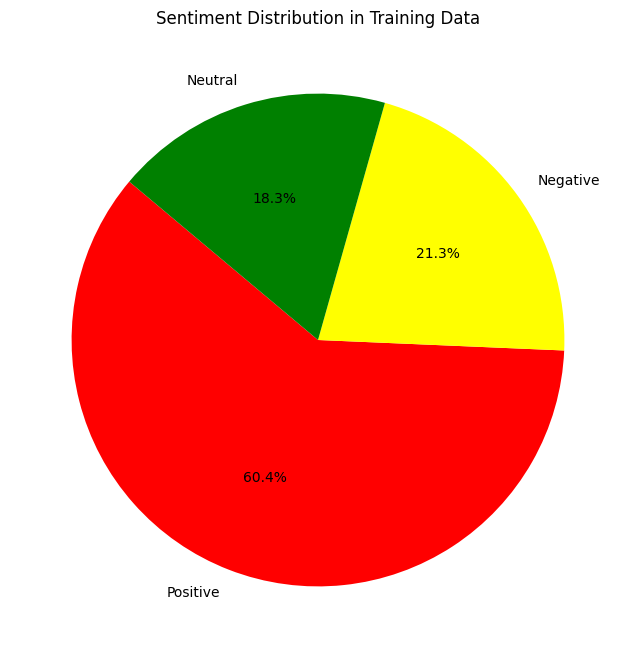

In [17]:
# EDA: Pie chart for sentiment distribution in training data
plt.figure(figsize=(8, 8))
train_sentiment_counts = train_data['sentiment'].value_counts()
plt.pie(train_sentiment_counts, labels=train_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['red', 'yellow', 'green'])
plt.title('Sentiment Distribution in Training Data')
plt.show()

In [18]:
train_sentiment_counts.index

Index(['Positive', 'Negative', 'Neutral'], dtype='object', name='sentiment')

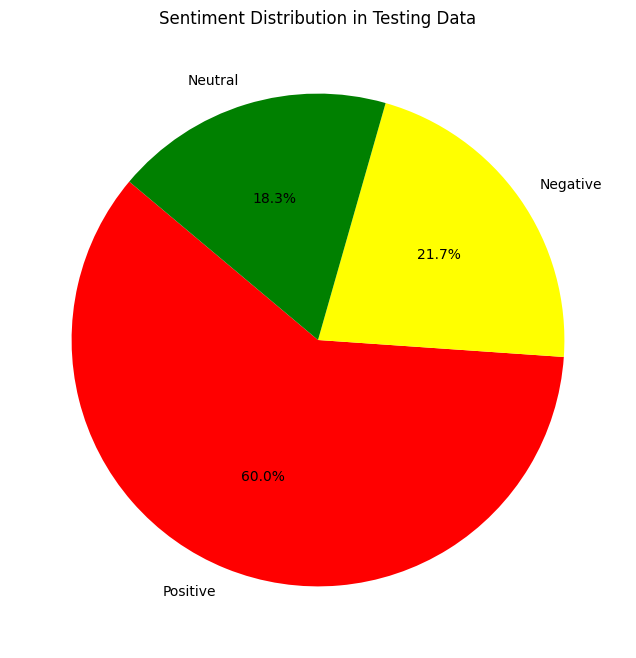

In [19]:
# EDA: Pie chart for sentiment distribution in testing data
plt.figure(figsize=(8, 8))
test_sentiment_counts = test_data['sentiment'].value_counts()
plt.pie(test_sentiment_counts, labels=test_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['red', 'yellow', 'green'])
plt.title('Sentiment Distribution in Testing Data')
plt.show()

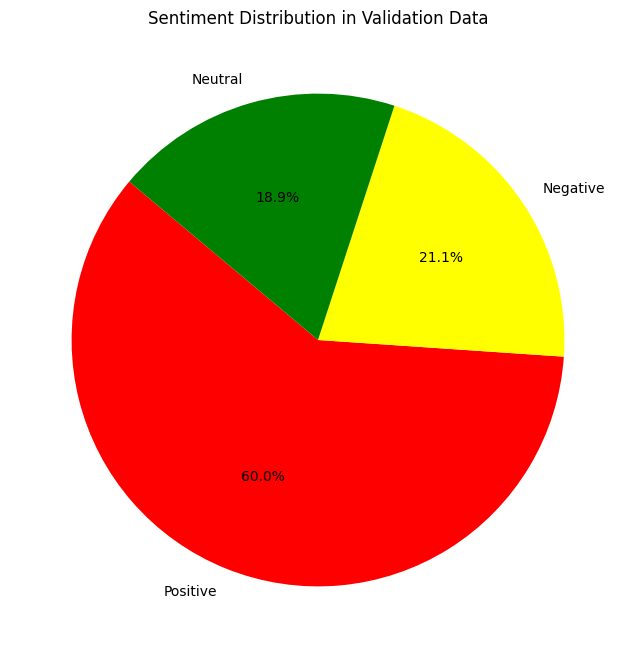

In [20]:
# EDA: Pie chart for sentiment distribution in validation data
plt.figure(figsize=(8, 8))
val_sentiment_counts = val_data['sentiment'].value_counts()
plt.pie(val_sentiment_counts, labels=val_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['red', 'yellow', 'green'])
plt.title('Sentiment Distribution in Validation Data')
plt.show()

In [21]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['review'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['review'])
X_val_tfidf = tfidf_vectorizer.transform(val_data['review'])

In [23]:
# Print original class distribution
print("Original class distribution:", Counter(train_data['sentiment']))

Original class distribution: Counter({'Positive': 66967, 'Negative': 23602, 'Neutral': 20242})


In [24]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, train_data['sentiment'])

In [51]:
# Print resampled class distribution
print("Resampled class distribution:", Counter(y_train_resampled))

Resampled class distribution: Counter({'Negative': 66967, 'Neutral': 66967, 'Positive': 66967})


In [52]:
import time

In [54]:
# Train the Naive Bayes model
nb_model = MultinomialNB()

# Make predictions on the test dataset
start_time_nb = time.time()

# Train the Naive Bayes model
nb_model.fit(X_train_tfidf_resampled, y_train_resampled)

# Make predictions on the test dataset
y_test_pred = nb_model.predict(X_test_tfidf)

end_time_nb = time.time()

nb_time = end_time_nb - start_time_nb
print(f"Naive Bayes Model Computational Time: {nb_time:.2f} seconds")

# Make predictions on the validation dataset
y_val_pred = nb_model.predict(X_val_tfidf)

Naive Bayes Model Computational Time: 1.62 seconds


In [44]:
# Evaluate the model on the test dataset
test_accuracy = accuracy_score(test_data['sentiment'], y_test_pred)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(test_data['sentiment'], y_test_pred))
test_cm = confusion_matrix(test_data['sentiment'], y_test_pred, labels=['Negative', 'Neutral', 'Positive'])
print(f'Confusion Matrix (Test):\n{test_cm}')

Test Accuracy: 0.7730979439576646
              precision    recall  f1-score   support

    Negative       0.76      0.78      0.77      9993
     Neutral       0.51      0.70      0.59      8444
    Positive       0.90      0.79      0.84     27671

    accuracy                           0.77     46108
   macro avg       0.72      0.76      0.73     46108
weighted avg       0.80      0.77      0.78     46108

Confusion Matrix (Test):
[[ 7795  1316   882]
 [ 1064  5912  1468]
 [ 1452  4280 21939]]


In [45]:
# Evaluate the model on the validation dataset
val_accuracy = accuracy_score(val_data['sentiment'], y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(val_data['sentiment'], y_val_pred))
val_cm = confusion_matrix(val_data['sentiment'], y_val_pred, labels=['Negative', 'Neutral', 'Positive'])
print(f'Confusion Matrix (Validation):\n{val_cm}')

Validation Accuracy: 0.7747536367902393
              precision    recall  f1-score   support

    Negative       0.76      0.78      0.77      5834
     Neutral       0.52      0.71      0.60      5238
    Positive       0.91      0.79      0.85     16631

    accuracy                           0.77     27703
   macro avg       0.73      0.76      0.74     27703
weighted avg       0.80      0.77      0.78     27703

Confusion Matrix (Validation):
[[ 4575   762   497]
 [  657  3696   885]
 [  825  2614 13192]]


In [55]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=10, random_state=42,n_jobs=-1)

start_time_rf = time.time()
rf_model.fit(X_train_tfidf_resampled, y_train_resampled)
y_test_pred_rf = rf_model.predict(X_test_tfidf)
rf_time = time.time() - start_time_rf
print(f"Random Forest Model Computational Time: {rf_time:.2f} seconds")

# Make predictions on the validation dataset
y_val_pred_rf = rf_model.predict(X_val_tfidf)

# Evaluate the model on the test dataset
rf_test_accuracy = accuracy_score(test_data['sentiment'], y_test_pred_rf)
print(f'Random Forest Test Accuracy: {rf_test_accuracy}')
print(classification_report(test_data['sentiment'], y_test_pred_rf))
rf_test_cm = confusion_matrix(test_data['sentiment'], y_test_pred_rf, labels=['Negative', 'Neutral', 'Positive'])
print(f'Confusion Matrix (Test):\n{rf_test_cm}')

# Evaluate the model on the validation dataset
rf_val_accuracy = accuracy_score(val_data['sentiment'], y_val_pred_rf)
print(f'Random Forest Validation Accuracy: {rf_val_accuracy}')
print(classification_report(val_data['sentiment'], y_val_pred_rf))
rf_val_cm = confusion_matrix(val_data['sentiment'], y_val_pred_rf, labels=['Negative', 'Neutral', 'Positive'])
print(f'Confusion Matrix (Validation):\n{rf_val_cm}')


Random Forest Model Computational Time: 326.71 seconds
Random Forest Test Accuracy: 0.8005985946039733
              precision    recall  f1-score   support

    Negative       0.77      0.67      0.72      9993
     Neutral       0.79      0.53      0.64      8444
    Positive       0.81      0.93      0.87     27671

    accuracy                           0.80     46108
   macro avg       0.79      0.71      0.74     46108
weighted avg       0.80      0.80      0.79     46108

Confusion Matrix (Test):
[[ 6666   406  2921]
 [  838  4487  3119]
 [ 1133   777 25761]]
Random Forest Validation Accuracy: 0.8000938526513374
              precision    recall  f1-score   support

    Negative       0.76      0.66      0.71      5834
     Neutral       0.79      0.53      0.64      5238
    Positive       0.81      0.93      0.87     16631

    accuracy                           0.80     27703
   macro avg       0.79      0.71      0.74     27703
weighted avg       0.80      0.80      0.79    

In [46]:
from sklearn.linear_model import SGDClassifier

# Train the SGD model
sgd_model = SGDClassifier(loss='modified_huber',random_state=42)

start_time_sgd = time.time()
sgd_model.fit(X_train_tfidf_resampled, y_train_resampled)
y_test_pred_sgd = sgd_model.predict(X_test_tfidf)
sgd_time = time.time() - start_time_sgd
print(f"SGD Model Computational Time: {sgd_time:.2f} seconds")


# Make predictions with the SGD model on the validation dataset
y_val_pred_sgd = sgd_model.predict(X_val_tfidf)

# Evaluate the SGD model on the test dataset
sgd_test_accuracy = accuracy_score(test_data['sentiment'], y_test_pred_sgd)
print(f'SGD Test Accuracy: {sgd_test_accuracy}')
print(classification_report(test_data['sentiment'], y_test_pred_sgd))
sgd_test_cm = confusion_matrix(test_data['sentiment'], y_test_pred_sgd, labels=['Negative', 'Neutral', 'Positive'])
print(f'Confusion Matrix (Test - SGD):\n{sgd_test_cm}')

# Evaluate the SGD model on the validation dataset
sgd_val_accuracy = accuracy_score(val_data['sentiment'], y_val_pred_sgd)
print(f'SGD Validation Accuracy: {sgd_val_accuracy}')
print(classification_report(val_data['sentiment'], y_val_pred_sgd))
sgd_val_cm = confusion_matrix(val_data['sentiment'], y_val_pred_sgd, labels=['Negative', 'Neutral', 'Positive'])
print(f'Confusion Matrix (Validation - SGD):\n{sgd_val_cm}')

SGD Model Computational Time: 9.17 seconds
SGD Test Accuracy: 0.7790405135768197
              precision    recall  f1-score   support

    Negative       0.71      0.77      0.74      9993
     Neutral       0.56      0.55      0.56      8444
    Positive       0.88      0.85      0.86     27671

    accuracy                           0.78     46108
   macro avg       0.71      0.73      0.72     46108
weighted avg       0.78      0.78      0.78     46108

Confusion Matrix (Test - SGD):
[[ 7730  1170  1093]
 [ 1517  4678  2249]
 [ 1601  2558 23512]]
SGD Validation Accuracy: 0.7787965202324658
              precision    recall  f1-score   support

    Negative       0.71      0.76      0.73      5834
     Neutral       0.57      0.56      0.56      5238
    Positive       0.88      0.85      0.86     16631

    accuracy                           0.78     27703
   macro avg       0.72      0.73      0.72     27703
weighted avg       0.78      0.78      0.78     27703

Confusion Matrix (